In [3]:
import pandas as pd
import pwlf
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
def outflow_curve_filter(outflow_df, pump_number, feature, bin_size, delay, pump_selection = False):
    # Prepare column names based on the selected pump number
    if pump_selection == True:
        if pump_number == 1:
            outflow_df[(outflow_df['pump1_speed'] > 0) & (outflow_df['pump3_speed'] == 0) & (outflow_df['pump4_speed'] == 0)]
        elif pump_number == 3:
            outflow_df[(outflow_df['pump1_speed'] == 0) & (outflow_df['pump3_speed'] >= 0) & (outflow_df['pump4_speed'] == 0)]
        elif pump_number == 4:
            outflow_df[(outflow_df['pump1_speed'] == 0) & (outflow_df['pump3_speed'] == 0) & (outflow_df['pump3_speed'] > 0)]
            
        pump_speed_col = f'pump{pump_number}_speed'
    
    outflow_df = outflow_df[outflow_df["time"] <= '2024-01-01'].reset_index()
    
    outflow_df.loc[outflow_df[pump_speed_col] <= 0, 'outflow'] = 0
    outflow_df.loc[outflow_df[pump_speed_col] < 0, pump_speed_col] = 0
    
    outflow_df = outflow_df[(outflow_df["outflow"] >= 0) & (outflow_df["outflow"] < 1000)]
    outflow_df["outflow"] = outflow_df["outflow"].shift(delay)
    
    max_speed = outflow_df[pump_speed_col].max()
    bins = range(0, int(max_speed) + bin_size, bin_size)
    
    # Bin the pump speeds
    outflow_df['speed_bin'] = pd.cut(outflow_df[pump_speed_col], bins, right=False)
    
    # Group by the new 'speed_bin' column and calculate mean values
    outflow_df = outflow_df.groupby('speed_bin')[[feature, pump_speed_col]].mean().reset_index()
    
    # Calculate the midpoint of each speed bin
    outflow_df['speed_mid'] = outflow_df['speed_bin'].apply(lambda x: (x.left + x.right) / 2)
    
    return outflow_df.dropna()

In [5]:
outflow_df  = pd.read_parquet("../data/static_models/outflow_miso.par")

pump1_power_df = pd.read_parquet("../data/static_models/pump1_power_siso.par")
#pump4_power_df = pd.read_parquet("./data/static_models/pump4_power_siso.par")
#pump3_power_df = pd.read_parquet("./data/static_models/pump3_power_siso.par")

In [6]:
import pandas as pd

def min_max_speed_scaler(column):
    min_val = 0
    max_val = 1500
    
    if min_val == max_val:
        return pd.Series([0] * len(column))  # If all values are the same, return a column of zeros
    
    # Scale column
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

In [7]:
import pandas as pd

def min_max_outflow_scaler(column):
    min_val = 0
    max_val = 800
    
    if min_val == max_val:
        return pd.Series([0] * len(column))  # If all values are the same, return a column of zeros
    
    # Scale column
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

In [8]:
static_qout_p1 = outflow_curve_filter(outflow_df = outflow_df,
                                           pump_number = 1,
                                           feature = "outflow",
                                           bin_size = 10, 
                                           delay=2,
                                           pump_selection=True)


/tmp/ipykernel_571/805980566.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outflow_df = outflow_df.groupby('speed_bin')[[feature, pump_speed_col]].mean().reset_index()


In [9]:
def fit_piecewise_outflow(outflow_static_curve_df: pd.DataFrame, breakpoints: list, pump_number: int):
    
    pwlf_model = None
    pump_speed_col = f'pump{pump_number}_speed'
    pwlf_model = pwlf.PiecewiseLinFit(outflow_static_curve_df[pump_speed_col], outflow_static_curve_df["outflow"])
    pwlf_model.fit_with_breaks(breakpoints)
    yhat = pwlf_model.predict(outflow_static_curve_df[pump_speed_col])
    print(pwlf_model.beta)
    
    return outflow_static_curve_df[pump_speed_col],  outflow_static_curve_df["outflow"],  yhat 

In [10]:
x, y, yhat = fit_piecewise_outflow(outflow_static_curve_df= static_qout_p1, 
                      breakpoints=[0, 600, np.max(static_qout_p1["pump1_speed"])], 
                      pump_number=1)

[21.44427517  0.11446284  0.64717553]


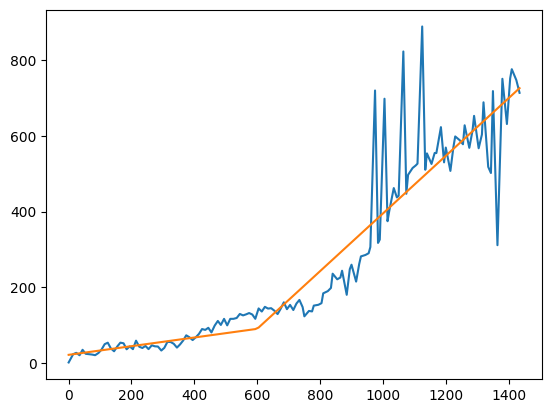

In [11]:
plt.plot(x,y)
plt.plot(x,yhat)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system parameters from your affine model
a1 = 0.08378681
b1 = 3.2216
speed_breakpoint = 600
tau = 20  # Time constant for introducing dynamics
x0 = 0
y0 = 0
# Define the state-space model
def state_space(t, x, w):
    if w <= speed_breakpoint:
        # Region 1
        a = a1
        b = b1
    else:
        # Region 2
        a = 0.8371
        b = 3.22 + 0.083 * 600 - 0.8371 * 600  # Offset ensuring continuity

    # State equation: τ * dx/dt + x = a * w + b
    dxdt = (-1/tau) * x + (1/tau) * (a * w + b)
    return dxdt


def input_signal_rect(t):
    # Rectangular wave oscillating between 0 and 1500
    return 1500 if (t // 100) % 2 == 0 else 0


# Time span for simulation
t_span = (0, 1000)
t_eval = np.linspace(t_span[0], t_span[1], 1000)


In [32]:
# Solve the state-space model with the rectangular input signal
sol_rect = solve_ivp(
    lambda t, x: state_space(t, x, input_signal_rect(t)),
    t_span,
    x0,
    t_eval=t_eval
)

# Plotting the state response for the rectangular input
plt.figure(figsize=(10, 6))
plt.plot(sol_rect.t, sol_rect.y, label="Output $y(t)$ with Rectangular Input", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Output $y(t)$")
plt.grid(True)
plt.legend()
plt.show()


ValueError: `y0` must be 1-dimensional.

In [27]:
pump_speed_data = outflow_df["pump1_speed"].values

KeyError: 'pump1_speed'

In [17]:
# Define the system parameters for the affine state-space model
a1 = 0.08378681
b1 = 3.2216
speed_breakpoint = 600
tau = 5  # Time constant for introducing dynamics

# Define the state-space model for different time constants
def state_space_dynamic(t, x, w, tau):
    # Determine the region and corresponding parameters based on the input speed
    if w <= speed_breakpoint:
        # Region 1
        a = a1
        b = b1
    else:
        # Region 2
        a = 0.8371
        b = 3.22 + 0.083 * 600 - 0.8371 * 600  # Offset ensuring continuity

    # State equation: τ * dx/dt + x = a * w + b
    dxdt = (-1 / tau) * x + (1 / tau) * (a * w + b)
    return dxdt

# Function to simulate the dynamic state response given the pump speed data
def simulate_dynamic_outflow(pump_speed_data, tau, t_eval):
    outflow = []

    # Initial state
    x = 0

    # Iterate over each time step to simulate the response
    for i, w in enumerate(pump_speed_data):
        t = t_eval[i]
        dt = t_eval[1] - t_eval[0] if i > 0 else t_eval[i]  # Time step size

        # Use Euler's method to approximate the state at the next time step
        dxdt = state_space_dynamic(t, x, w, tau)
        x = x + dxdt * dt

        # Store the output
        outflow.append(x)

    return np.array(outflow)
